# nPRFs & GMs ?

In [1]:
import numpy as np
import nibabel as nib
from nilearn import datasets
import os.path as op
import os
import pandas as pd

bids_folder = '/mnt_03/ds-dnumrisk' 
key = 'encoding_model.denoise'

In [8]:
nPRF_dir = op.join(bids_folder,'derivatives',key,'averages')
group = 'all'
par = 'r2'
space = 'fsaverage5'

hemi='L'
nPRF_fn =  op.join(nPRF_dir, f'group-{group}_desc-{par}.optim.nilearn_space-{space}_hemi-{hemi}.func.gii')
nprf_r2_L = nib.load(nPRF_fn).agg_data()
hemi='R'
nPRF_fn =  op.join(nPRF_dir, f'group-{group}_desc-{par}.optim.nilearn_space-{space}_hemi-{hemi}.func.gii')
nprf_r2_R = nib.load(nPRF_fn).agg_data()

np.shape(nprf_r2_R)

(10242,)

In [9]:
sub='All'
n_comp = 10
grad_folder = 'derivatives/gradients'
fn = op.join(bids_folder,grad_folder,f'sub-{sub}',f'sub-{sub}_gradients_N-{n_comp}.npy')
grad = np.load(fn)

n_grad=1
gm = np.split(grad[n_grad-1],2) 
np.shape(gm)

(2, 10242)

In [10]:
from  nilearn.datasets import fetch_surf_fsaverage

fsaverage = fetch_surf_fsaverage(space) 

surf_lh, surf_rh = fsaverage.pial_left , fsaverage.pial_right # load_conte69() = surf : tuple of BSPolyData or BSPolyData
sphere_lh, sphere_rh = fsaverage.sphere_left , fsaverage.sphere_right

#pati = '/mnt_03/ds-dnumrisk/derivatives/freesurfer/fsaverage5/surf/' ; import nilearn.plotting as nplt


In [11]:
from brainspace.mesh.mesh_io import read_surface

surf_lh = read_surface(surf_lh)
surf_rh = read_surface(surf_rh)

sphere_lh = read_surface(sphere_lh)
sphere_rh = read_surface(sphere_rh)


In [12]:
from brainspace.null_models import SpinPermutations

n_rand = 1000
sp = SpinPermutations(n_rep=n_rand, random_state=0)
sp.fit(sphere_lh, points_rh=sphere_rh)

SpinPermutations(n_rep=1000, random_state=0)

In [13]:
nPRF_rotated = np.hstack(sp.randomize(nprf_r2_L, nprf_r2_R))
gm_rotated = np.hstack(sp.randomize(gm[0], gm[1]))

In [ ]:
# this makes the kernel crash!
#from brainspace.plotting import plot_hemispheres

plot_hemispheres(surf_lh, surf_rh, array_name=nPRF_rotated[:3], size=(1200, 600),
                 cmap='viridis', nan_color=(0.5, 0.5, 0.5, 1), color_bar=True,
                 zoom=1.55, label_text=['Rot0', 'Rot1', 'Rot2'])

In [16]:
np.shape(nprf_r2_L)

(10242,)

Gradients:
 Obs : 0.00000e+00
 Spin: 0.00000e+00

Nprfs_r2:
 Obs : 9.90924e-119
 Spin: 6.02000e-01



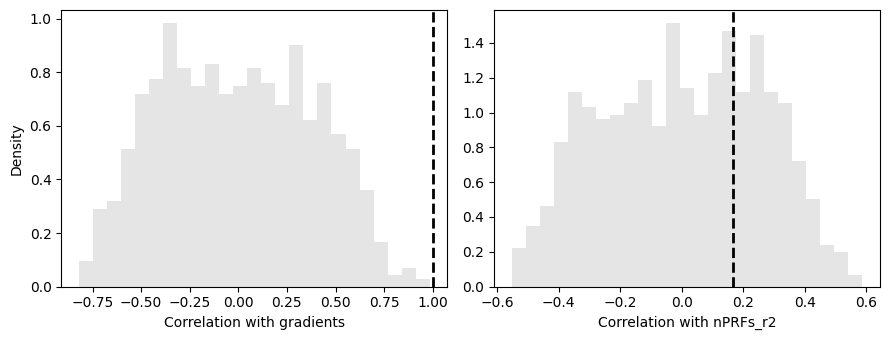

In [18]:
from matplotlib import pyplot as plt
from scipy.stats import spearmanr

fig, axs = plt.subplots(1, 2, figsize=(9, 3.5))


nprf_r2 = np.concatenate((nprf_r2_L, nprf_r2_R))
gradients = np.concatenate((gm[0], gm[1]))
feats = {'gradients': gradients, 'nPRFs_r2': nprf_r2}
rotated = {'gradients': gm_rotated, 'nPRFs_r2': nPRF_rotated}

r_spin = np.empty(n_rand)

mask = ~np.isnan(gradients)
for k, (fn, feat) in enumerate(feats.items()):
    r_obs, pv_obs = spearmanr(feat[mask], gradients[mask])

    # Compute perm pval
    for i, perm in enumerate(rotated[fn]):
        mask_rot = mask & ~np.isnan(perm)  # Remove midline
        r_spin[i] = spearmanr(perm[mask_rot], gradients[mask_rot])[0]
    pv_spin = np.mean(np.abs(r_spin) >= np.abs(r_obs))

    # Plot null dist
    axs[k].hist(r_spin, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
    axs[k].axvline(r_obs, lw=2, ls='--', color='k')
    axs[k].set_xlabel(f'Correlation with {fn}')
    if k == 0:
        axs[k].set_ylabel('Density')

    print(f'{fn.capitalize()}:\n Obs : {pv_obs:.5e}\n Spin: {pv_spin:.5e}\n')

fig.tight_layout()
plt.show()

In [27]:
sub='All'
n_comp = 10
grad_folder = 'derivatives/gradients'
fn = op.join(bids_folder,grad_folder,f'sub-{sub}',f'sub-{sub}_gradients_N-{n_comp}.npy')
grad = np.load(fn)

feats = {}
rotated = {}
for n_grad in range(5,10):
    gm = np.split(grad[n_grad],2) 
    gradients = np.concatenate((gm[0], gm[1]))
    gm_rotated = np.hstack(sp.randomize(gm[0], gm[1]))

    feats[f'grad{n_grad+1}'] = gradients
    rotated[f'grad{n_grad+1}'] = gm_rotated


Grad6:
 Obs : 1.89831e-39
 Spin: 3.96000e-01

Grad7:
 Obs : 2.76441e-12
 Spin: 6.74000e-01

Grad8:
 Obs : 1.87372e-76
 Spin: 4.85000e-01

Grad9:
 Obs : 4.01841e-06
 Spin: 7.60000e-01

Grad10:
 Obs : 1.29153e-09
 Spin: 6.29000e-01



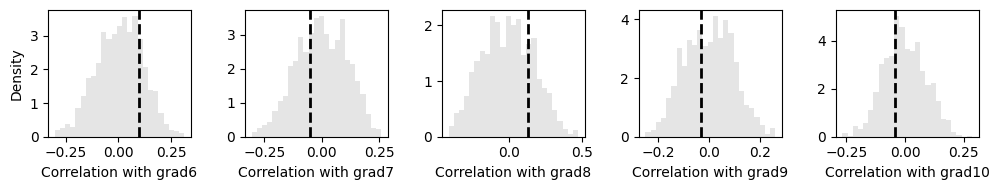

In [28]:
import seaborn as sns

fig, axs = plt.subplots(1, len(feats), figsize=(len(feats)*2, 2))

for k, (fn, feat) in enumerate(feats.items()):
    r_obs, pv_obs = spearmanr(feat[mask], nprf_r2[mask])

    # Compute perm pval
    for i, perm in enumerate(rotated[fn]):
        mask_rot = mask & ~np.isnan(perm)  # Remove midline
        r_spin[i] = spearmanr(perm[mask_rot], nprf_r2[mask_rot])[0]
    pv_spin = np.mean(np.abs(r_spin) >= np.abs(r_obs))

    # Plot null dist
    axs[k].hist(r_spin, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
    axs[k].axvline(r_obs, lw=2, ls='--', color='k')
    axs[k].set_xlabel(f'Correlation with {fn}')
    axs[k].set_title(f'Obs : {pv_obs:.2e}\n Spin: {pv_spin:.2e}')
    if k == 0:
        axs[k].set_ylabel('Density')

    print(f'{fn.capitalize()}:\n Obs : {pv_obs:.5e}\n Spin: {pv_spin:.5e}\n')

fig.tight_layout()
sns.despine()

plt.show()



In [ ]:
import nilearn.plotting as nplt
import matplotlib.pyplot as plt


In [ ]:
import nilearn.plotting as nplt
import matplotlib.pyplot as plt


# addtional stuff

In [ ]:
from nipype.interfaces.freesurfer import SurfaceTransform # needs the fsaverage & fsaverage5 in ..derivatives/freesurfer folder!
source_space = 'fsaverage'
target_space = 'fsaverage5'

for hemi in ['L', 'R']:
    sxfm = SurfaceTransform(subjects_dir=op.join(bids_folder,'derivatives','freesurfer'))

    sxfm.inputs.source_file = op.join(nPRF_dir, f'group-{group}_desc-{par}.optim.nilearn_space-{source_space}_hemi-{hemi}.func.gii')
    sxfm.inputs.out_file = op.join(nPRF_dir, f'group-{group}_desc-{par}.optim.nilearn_space-{target_space}_hemi-{hemi}.func.gii')
    sxfm.inputs.source_subject = source_space 
    sxfm.inputs.target_subject = target_space 
    sxfm.inputs.hemi = 'lh' if hemi == 'L' else 'rh'

    r = sxfm.run()